*Author: Sraddha Bhattacharjee*

**Mount drive path**

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Question 1 solution**

In [30]:
import pandas as pd

# Load the sales data
df = pd.read_csv("/content/drive/MyDrive/sales.csv", parse_dates=['orderdate'])

# Step 1: Identify the first order date for each customer
customer_first_order = df.groupby('customer_number')['orderdate'].min().reset_index()
customer_first_order.columns = ['customer_number', 'first_order_date']

# Step 2: Merge the first order date back into the original dataframe
df = pd.merge(df, customer_first_order, on='customer_number')

# Step 3: Classify each order as new or returning
df['order_year'] = df['orderdate'].dt.year
df['customer_type'] = df.apply(lambda row: 'New' if row['orderdate'].year == row['first_order_date'].year else 'Returning', axis=1)

# Step 4: Count the number of new and returning customers per year
yearly_customer_count = df.groupby(['order_year', 'customer_type'])['customer_number'].nunique().reset_index()
yearly_customer_count.columns = ['Year', 'CustomerType', 'CustomerCount']

# Step 5: Calculate the total number of customers per year
total_customers_per_year = yearly_customer_count.groupby('Year')['CustomerCount'].sum().reset_index()
total_customers_per_year.columns = ['Year', 'TotalCustomers']

# Step 6: Merge the total customers per year back into the yearly customer count dataframe
yearly_customer_count = pd.merge(yearly_customer_count, total_customers_per_year, on='Year')

# Step 7: Calculate the portion of new and returning customers
yearly_customer_count['Portion'] = yearly_customer_count['CustomerCount'] / yearly_customer_count['TotalCustomers']

# Step 8: Pivot the dataframe to get the desired format
result = yearly_customer_count.pivot(index='Year', columns='CustomerType', values='Portion').fillna(0)

# Step 9 : Add new + returning column values which always add to 1

result['Total'] = result.sum(axis=1)

print(result)


CustomerType       New  Returning  Total
Year                                    
2018          1.000000   0.000000    1.0
2019          0.660721   0.339279    1.0
2020          0.624806   0.375194    1.0
2021          0.468724   0.531276    1.0
2022          1.000000   0.000000    1.0
2023          0.516129   0.483871    1.0


 **Question 2 solution:**

In [31]:
import pandas as pd

# Step 1: Load the data from the CSV file
df = pd.read_csv("/content/drive/MyDrive/sales.csv")

# Step 2: Identify and Remove Outliers using the IQR method
def remove_outliers(group):
    Q1 = group['QuantityOrdered'].quantile(0.25)
    Q3 = group['QuantityOrdered'].quantile(0.75)
    IQR = Q3 - Q1
    return group[(group['QuantityOrdered'] >= (Q1 - 1.5 * IQR)) & (group['QuantityOrdered'] <= (Q3 + 1.5 * IQR))]

df_no_outliers = df.groupby('sku_id').apply(remove_outliers).reset_index(drop=True)



In [41]:
import pandas as pd

# Convert 'orderdate' column to datetime format
df_no_outliers['orderdate'] = pd.to_datetime(df_no_outliers['orderdate'])

# Extract the year from 'orderdate' and create a new column 'order_year'
df_no_outliers['order_year'] = df_no_outliers['orderdate'].dt.year

# Group by 'order_year' and 'sku_id' to calculate average demand
# For each SKU and year, calculate the average quantity ordered
average_demand = df_no_outliers.groupby(['order_year', 'sku_id'])['QuantityOrdered'].mean().reset_index()

# Display the DataFrame with average demand per year for each SKU
print(average_demand)



       order_year      sku_id  QuantityOrdered
0            2018  1109285499         1.375000
1            2018  1109285500         4.000000
2            2018  1109285501         3.700000
3            2018  1109285502         1.000000
4            2018  1109285503         1.312883
...           ...         ...              ...
73094        2023  1109317660         1.000000
73095        2023  1109317783         1.000000
73096        2023  1109381246         1.000000
73097        2023  1109382949         1.000000
73098        2023  1109382953         1.000000

[73099 rows x 3 columns]


In [42]:
# Shows number of unique rows in the output
len(average_demand.sku_id.unique())

22743

**Running Linear Regression model to predict next year's demand**

In [35]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np

# Linear regression function to predict next year's demand
def predict_next_year_demand(df):
    results = []
    for sku_id, group in df.groupby('sku_id'):
        X = group['order_year'].values.reshape(-1, 1)
        y = group['QuantityOrdered'].values

        if len(group) < 2:  # Not enough data points for a linear model
            predicted_demand = y[0]  # Use the same quantity for the forecast
        else:
            # Train the model
            model = LinearRegression()
            model.fit(X, y)

            # Predict the demand for the next year (max year + 1)
            next_year = group['order_year'].max() + 1
            predicted_demand = model.predict(np.array([[next_year]]))[0]

        results.append({'sku_id': sku_id, 'quantity': predicted_demand})

    return pd.DataFrame(results)

# Predict the next year's demand for each sku_id
predicted_demand_df = predict_next_year_demand(average_demand)
predicted_demand_df


,sku_id,quantity
0,81588,1.000000
1,710294272,1.000000
2,1109285499,1.180147
3,1109285500,0.425000
4,1109285501,7.644505
...,...,...
22738,1109410606,1.000000
22739,1109410610,1.000000
22740,1109410613,1.000000
22741,1109411156,3.000000


**As an additional step I created predicted_demand_adjusted table which adjusts the predicted quantities:**

a) Sets values between 0 and 1 to 1.

b)Sets non-positive values to 0.

c) Leaves other values unchanged.

**To ensure practical forecasted stock levels, I adjusted the Linear Regression model's predictions by setting quantities to zero or one when they are close to zero, preventing unrealistic negative forecasts**.

In [39]:
# Adjust the quantities
predicted_demand_adjusted = predicted_demand_df.copy()
predicted_demand_adjusted['quantity'] = predicted_demand_adjusted['quantity'].apply(
    lambda x: 1 if 0 < x < 1 else (0 if x <= 0 else x)
)

# Display the adjusted DataFrame
predicted_demand_adjusted


,sku_id,quantity
0,81588,1.000000
1,710294272,1.000000
2,1109285499,1.180147
3,1109285500,1.000000
4,1109285501,7.644505
...,...,...
22738,1109410606,1.000000
22739,1109410610,1.000000
22740,1109410613,1.000000
22741,1109411156,3.000000


**Reading the final data with sku_id and adjusted quantities to a csv named 'pred_demand'.**

In [40]:
output_file_path = '/content/drive/MyDrive/pred_demand.csv'  # Update this to the desired output path
predicted_demand_adjusted.to_csv(output_file_path, index=False)

**Plotting the average demand graph for a random sku_id (= 1109286010) with with data from previous years along with data predicted by the Linear Regression model for the next year**

In [60]:
sample_row = average_demand[average_demand['sku_id'] == 1109286010]
sample_row


,order_year,sku_id,QuantityOrdered
224,2018,1109286010,145.777778
16221,2019,1109286010,159.933333
33799,2020,1109286010,194.484848
53901,2021,1109286010,220.520000


In [64]:
sample_row_predicted_value = predicted_demand_adjusted[predicted_demand_adjusted['sku_id'] == 1109286010]
sample_row_predicted_value['order_year'] = 2022
sample_row_predicted_value.columns = ['sku_id', 'QuantityOrdered', 'order_year']
sample_row_predicted_value

<ipython-input-64-01ea5566cbdd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_row_predicted_value['order_year'] = 2022


,sku_id,QuantityOrdered,order_year
241,1109286010,244.873535,2022


In [65]:
plot_df = pd.concat([sample_row, sample_row_predicted_value])
plot_df

,order_year,sku_id,QuantityOrdered
224,2018,1109286010,145.777778
16221,2019,1109286010,159.933333
33799,2020,1109286010,194.484848
53901,2021,1109286010,220.520000
241,2022,1109286010,244.873535


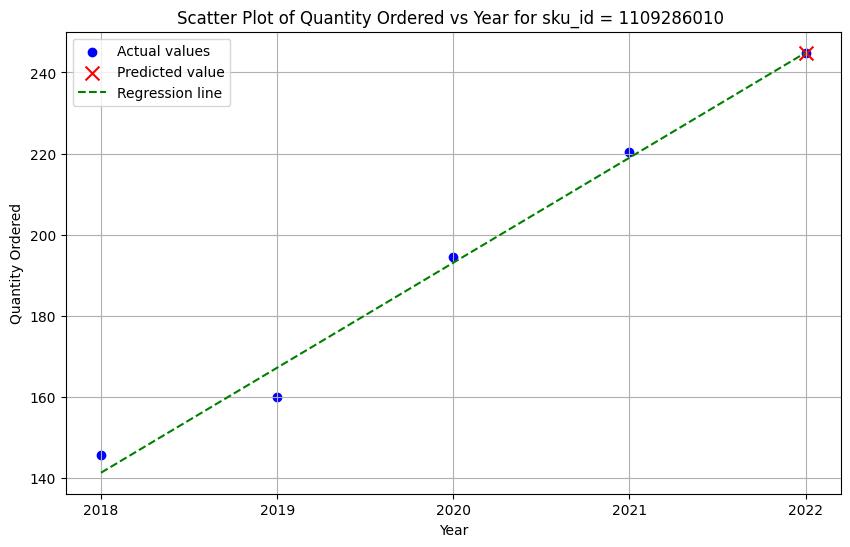

In [70]:
import matplotlib.pyplot as plt
# Create the scatter plot
plt.figure(figsize=(10, 6))

# Plot all points
plt.scatter(plot_df['order_year'], plot_df['QuantityOrdered'], color='blue', label='Actual values')

# Highlight the year 2022 with a different style
df_2022 = plot_df[plot_df['order_year'] == 2022]
plt.scatter(df_2022['order_year'], df_2022['QuantityOrdered'], color='red', marker='x', s=100, label='Predicted value')

# Fit a linear regression model
X = plot_df[['order_year']].values
y = plot_df['QuantityOrdered'].values
model = LinearRegression()
model.fit(X, y)

# Generate points for the regression line
x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_pred = model.predict(x_range)

# Plot the regression line
plt.plot(x_range, y_pred, color='green', linestyle='--', label='Regression line')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Quantity Ordered')
plt.title('Scatter Plot of Quantity Ordered vs Year for sku_id = 1109286010 ')
plt.legend()

# Set x-ticks to only show whole numbers
plt.xticks(np.arange(plot_df['order_year'].min(), plot_df['order_year'].max() + 1, 1))

# Show the plot
plt.grid(True)
plt.show()
